In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
# 데이터셋 불러오기
train_df = pd.read_csv('dataset/train_dataset.csv')
val_df = pd.read_csv('dataset/val_dataset.csv')
test_df = pd.read_csv('dataset/test_dataset.csv')

In [3]:
# 데이터프레임으로 변환
train_df = pd.DataFrame(train_df)
val_df = pd.DataFrame(val_df)
test_df = pd.DataFrame(test_df)

In [4]:
# 언더샘플링 데이터셋 불러오기
balanced_df = pd.read_csv('dataset/balanced_dataset.csv')
balanced_df.head(4)

,Path,Vehicle_ID,Turn,Lane,Speed,Hazard,ISSUE_DATE,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE,CURRENT_LANE,Group_ID
0,V_220902_C_A_A4ED90F2_066801.csv,A4ED90F2,Right,R-Side,False,True,2022-09-02 13:11:10,A4ED90F2,9228.0,126.857587,35.144362,264.0,7.0,0.0,28.0,bus,0,0
1,V_220902_C_A_A4ED90F2_066801.csv,A4ED90F2,Right,R-Side,False,True,2022-09-02 13:11:11,A4ED90F2,9228.0,126.857561,35.144360,264.0,7.0,0.0,0.0,bus,0,0
2,V_220902_C_A_A4ED90F2_066801.csv,A4ED90F2,Right,R-Side,False,True,2022-09-02 13:11:12,A4ED90F2,9228.0,126.857536,35.144357,262.0,7.0,0.0,28.0,bus,0,0
3,V_220902_C_A_A4ED90F2_066801.csv,A4ED90F2,Right,R-Side,False,True,2022-09-02 13:11:13,A4ED90F2,9228.0,126.857510,35.144357,266.0,7.0,0.0,0.0,bus,0,0


# 데이터 확인

In [7]:
train_df.head(11)

,Path,Vehicle_ID,Turn,Lane,Speed,Hazard,ISSUE_DATE,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE,CURRENT_LANE,Group_ID
0,V_220809_C_A_59168562_011790.csv,59168562,Right,R-Side,False,True,2022-08-09 15:42:30,59168562,9228.0,126.920616,35.142475,350.0,23.0,0.0,28.0,bus,0,2
1,V_220809_C_A_59168562_011790.csv,59168562,Right,R-Side,False,True,2022-08-09 15:42:31,59168562,9228.0,126.920610,35.142538,358.0,24.0,0.0,28.0,bus,0,2
2,V_220809_C_A_59168562_011790.csv,59168562,Right,R-Side,False,True,2022-08-09 15:42:32,59168562,9228.0,126.920613,35.142600,6.0,23.0,0.0,0.0,bus,0,2
3,V_220809_C_A_59168562_011790.csv,59168562,Right,R-Side,False,True,2022-08-09 15:42:33,59168562,9228.0,126.920626,35.142662,10.0,24.0,0.0,28.0,bus,0,2
4,V_220809_C_A_59168562_011790.csv,59168562,Right,R-Side,False,True,2022-08-09 15:42:34,59168562,9228.0,126.920649,35.142725,19.0,25.0,0.0,28.0,bus,0,2
5,V_220809_C_A_59168562_011790.csv,59168562,Right,R-Side,False,True,2022-08-09 15:42:35,59168562,9228.0,126.920676,35.142792,18.0,28.0,0.0,28.0,bus,0,2
6,V_220809_C_A_59168562_011790.csv,59168562,Right,R-Side,False,True,2022-08-09 15:42:36,59168562,9228.0,126.920707,35.142862,20.0,30.0,0.0,56.0,bus,0,2
7,V_220809_C_A_59168562_011790.csv,59168562,Right,R-Side,False,True,2022-08-09 15:42:37,59168562,9228.0,126.920740,35.142933,21.0,31.0,0.0,28.0,bus,0,2
8,V_220809_C_A_59168562_011790.csv,59168562,Right,R-Side,False,True,2022-08-09 15:42:38,59168562,9228.0,126.920777,35.143011,20.0,32.0,0.0,56.0,bus,0,2
9,V_220809_C_A_59168562_011790.csv,59168562,Right,R-Side,False,True,2022-08-09 15:42:39,59168562,9228.0,126.920820,35.143099,21.0,33.0,0.0,28.0,bus,0,2


In [8]:
val_df.head(11)

,Path,Vehicle_ID,Turn,Lane,Speed,Hazard,ISSUE_DATE,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE,CURRENT_LANE,Group_ID
0,V_221105_C_F_FFE811C9_000103.csv,FFE811C9,False,False,False,True,2022-11-05 11:40:37,FFE811C9,9220.0,126.871459,35.134052,52.0,10.0,80.0,0.0,car,0,1
1,V_221105_C_F_FFE811C9_000103.csv,FFE811C9,False,False,False,True,2022-11-05 11:40:38,FFE811C9,9220.0,126.871488,35.134069,54.0,12.0,80.0,56.0,car,0,1
2,V_221105_C_F_FFE811C9_000103.csv,FFE811C9,False,False,False,True,2022-11-05 11:40:39,FFE811C9,9220.0,126.871516,35.134086,52.0,10.0,80.0,-56.0,car,0,1
3,V_221105_C_F_FFE811C9_000103.csv,FFE811C9,False,False,False,True,2022-11-05 11:40:40,FFE811C9,9220.0,126.871537,35.134098,51.0,5.0,80.0,-83.0,car,0,1
4,V_221105_C_F_FFE811C9_000103.csv,FFE811C9,False,False,False,True,2022-11-05 11:40:41,FFE811C9,9220.0,126.871548,35.134105,51.0,2.0,80.0,-111.0,car,0,1
5,V_221105_C_F_FFE811C9_000103.csv,FFE811C9,False,False,False,True,2022-11-05 11:40:42,FFE811C9,9220.0,126.871554,35.134108,51.0,2.0,80.0,0.0,car,0,1
6,V_221105_C_F_FFE811C9_000103.csv,FFE811C9,False,False,False,True,2022-11-05 11:40:43,FFE811C9,9220.0,126.871560,35.134112,51.0,3.0,80.0,28.0,car,0,1
7,V_221105_C_F_FFE811C9_000103.csv,FFE811C9,False,False,False,True,2022-11-05 11:40:44,FFE811C9,9220.0,126.871570,35.134118,51.0,4.0,80.0,28.0,car,0,1
8,V_221105_C_F_FFE811C9_000103.csv,FFE811C9,False,False,False,True,2022-11-05 11:40:45,FFE811C9,9220.0,126.871583,35.134127,55.0,4.0,80.0,0.0,car,0,1
9,V_221105_C_F_FFE811C9_000103.csv,FFE811C9,False,False,False,True,2022-11-05 11:40:46,FFE811C9,9220.0,126.871599,35.134136,51.0,6.0,80.0,28.0,car,0,1


In [9]:
test_df.head(11)

,Path,Vehicle_ID,Turn,Lane,Speed,Hazard,ISSUE_DATE,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE,CURRENT_LANE,Group_ID
0,V_220902_C_A_A4ED90F2_066801.csv,A4ED90F2,Right,R-Side,False,True,2022-09-02 13:11:10,A4ED90F2,9228.0,126.857587,35.144362,264.0,7.0,0.0,28.0,bus,0,0
1,V_220902_C_A_A4ED90F2_066801.csv,A4ED90F2,Right,R-Side,False,True,2022-09-02 13:11:11,A4ED90F2,9228.0,126.857561,35.144360,264.0,7.0,0.0,0.0,bus,0,0
2,V_220902_C_A_A4ED90F2_066801.csv,A4ED90F2,Right,R-Side,False,True,2022-09-02 13:11:12,A4ED90F2,9228.0,126.857536,35.144357,262.0,7.0,0.0,28.0,bus,0,0
3,V_220902_C_A_A4ED90F2_066801.csv,A4ED90F2,Right,R-Side,False,True,2022-09-02 13:11:13,A4ED90F2,9228.0,126.857510,35.144357,266.0,7.0,0.0,0.0,bus,0,0
4,V_220902_C_A_A4ED90F2_066801.csv,A4ED90F2,Right,R-Side,False,True,2022-09-02 13:11:14,A4ED90F2,9228.0,126.857482,35.144357,274.0,9.0,0.0,28.0,bus,0,0
5,V_220902_C_A_A4ED90F2_066801.csv,A4ED90F2,Right,R-Side,False,True,2022-09-02 13:11:15,A4ED90F2,9228.0,126.857453,35.144360,281.0,11.0,0.0,56.0,bus,0,0
6,V_220902_C_A_A4ED90F2_066801.csv,A4ED90F2,Right,R-Side,False,True,2022-09-02 13:11:16,A4ED90F2,9228.0,126.857419,35.144373,303.0,13.0,0.0,56.0,bus,0,0
7,V_220902_C_A_A4ED90F2_066801.csv,A4ED90F2,Right,R-Side,False,True,2022-09-02 13:11:17,A4ED90F2,9228.0,126.857387,35.144399,325.0,12.0,0.0,-28.0,bus,0,0
8,V_220902_C_A_A4ED90F2_066801.csv,A4ED90F2,Right,R-Side,False,True,2022-09-02 13:11:18,A4ED90F2,9228.0,126.857366,35.144429,338.0,14.0,0.0,56.0,bus,0,0
9,V_220902_C_A_A4ED90F2_066801.csv,A4ED90F2,Right,R-Side,False,True,2022-09-02 13:11:19,A4ED90F2,9228.0,126.857356,35.144466,354.0,16.0,0.0,56.0,bus,0,0


In [5]:
# 언더샘플링 데이터셋의 돌발 상황 데이터 비율 확인
total = len(balanced_df)
print(f'전체 데이터 개수 : {total}')

hazard = balanced_df[balanced_df['Hazard'] == True]
print(f'돌발 상황 데이터 개수 : {len(hazard)}')

normal = balanced_df[balanced_df['Hazard'] == False]
print(f'정상 상황 데이터 개수 : {len(normal)}')

print('=================')

hazard_ratio = len(hazard) / total * 100
normal_ratio = len(normal) / total * 100
print(f'돌발 상황 비율 : {hazard_ratio:.3f}')
print(f'정상 상황 비율 : {normal_ratio:.3f}')

h = int(hazard_ratio / hazard_ratio)
n = int(normal_ratio / hazard_ratio)
print(f'정상 상황 : 돌발 상황 = {n} : {h}')

전체 데이터 개수 : 452490
돌발 상황 데이터 개수 : 150830
정상 상황 데이터 개수 : 301660
돌발 상황 비율 : 33.333
정상 상황 비율 : 66.667
정상 상황 : 돌발 상황 = 2 : 1


# 시퀀스 생성

In [4]:
# 데이터프레임을 시퀀스로 변환
def create_sequences(df, input_columns):
    """
    Group_ID를 기준으로 데이터를 묶어 시퀀스를 생성

    Parameters:
    - df (pd.DataFrame): 입력 데이터프레임 (Group_ID 포함)
    - input_columns (list): 모델 입력으로 사용할 칼럼 리스트

    Returns:
    - X (list of np.array): 각 그룹의 시퀀스 데이터
    - y (list): 각 시퀀스의 타겟 라벨
    
    """
    # X : 입력, y : 라벨
    X, y = [], []

    # Group_ID별로 데이터 묶기
    for group_id, group in df.groupby('Group_ID'):
        # 그룹의 입력 데이터 추출
        features = group[input_columns].values

        # 그룹의 타겟값 (예: 마지막 Hazard 값 사용)
        label = group['Hazard'].iloc[-1] 

        X.append(features)
        y.append(label)

    return np.array(X, dtype=object), np.array(y)

In [5]:
# 사용할 입력 칼럼을 지정
input_columns = [
    'LONGITUDE', 'LATITUDE', 
    'HEADING', 'SPEED', 'BRAKE_STATUS', 
    'ACC_SEC', 'CURRENT_LANE'
]

# 시퀀스 생성
X_train, y_train = create_sequences(train_df, input_columns)
X_val, y_val = create_sequences(val_df, input_columns)
X_test, y_test = create_sequences(test_df, input_columns)

X_train = np.array(X_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

print(f"Train Input Shape: {X_train.shape}")
print(f"Train Target Shape: {y_train.shape}")
print('=================')
print(f"Validation Input Shape: {X_val.shape}")
print(f"Validation Target Shape: {y_val.shape}")
print('=================')
print(f"Test Input Shape: {X_test.shape}")
print(f"Test Target Shape: {y_test.shape}")

Train Input Shape: (31674, 10, 7)
Train Target Shape: (31674,)
Validation Input Shape: (6787, 10, 7)
Validation Target Shape: (6787,)
Test Input Shape: (6788, 10, 7)
Test Target Shape: (6788,)


In [12]:
# 생성된 시퀀스 확인
print(f'Train Input Data : \n{X_train[0]}\n')
print(f'Train Target Data : {y_train[0]}')

Train Input Data : 
[[126.920616  35.142475 350.        23.         0.        28.
    0.      ]
 [126.92061   35.142536 358.        24.         0.        28.
    0.      ]
 [126.920616  35.1426     6.        23.         0.         0.
    0.      ]
 [126.92062   35.142662  10.        24.         0.        28.
    0.      ]
 [126.92065   35.142727  19.        25.         0.        28.
    0.      ]
 [126.92068   35.14279   18.        28.         0.        28.
    0.      ]
 [126.92071   35.14286   20.        30.         0.        56.
    0.      ]
 [126.92074   35.142933  21.        31.         0.        28.
    0.      ]
 [126.92078   35.14301   20.        32.         0.        56.
    0.      ]
 [126.92082   35.143097  21.        33.         0.        28.
    0.      ]]

Train Target Data : True


In [6]:
# 스케일러 생성
scaler = StandardScaler()

# 정규화는 훈련 데이터에서만 학습
X_train_flat = np.concatenate([x for x in X_train])  # 3D 데이터를 2D로 변환
scaler.fit(X_train_flat)  # 훈련 데이터로 스케일러 학습

# 훈련 데이터 정규화
X_train_scaled = []
for x in X_train:
    X_train_scaled.append(scaler.transform(x))
X_train_scaled = np.array(X_train_scaled, dtype=np.float32)

# 검증 데이터 정규화
X_val_scaled = []
for x in X_val:
    X_val_scaled.append(scaler.transform(x))
X_val_scaled = np.array(X_val_scaled, dtype=np.float32)

# 테스트 데이터 정규화
X_test_scaled = []
for x in X_test:
    X_test_scaled.append(scaler.transform(x))
X_test_scaled = np.array(X_test_scaled, dtype=np.float32)

# 정규화된 데이터 출력
print(f"Train Input Shape after Scaling: {X_train_scaled.shape}")
print(f"Validation Input Shape after Scaling: {X_val_scaled.shape}")
print(f"Test Input Shape after Scaling: {X_test_scaled.shape}")

Train Input Shape after Scaling: (31674, 10, 7)
Validation Input Shape after Scaling: (6787, 10, 7)
Test Input Shape after Scaling: (6788, 10, 7)


In [14]:
# 정규화 데이터 확인
print(f'Train Input Data after Scaling : \n{X_train_scaled[0]}\n')

Train Input Data after Scaling : 
[[-0.01928911 -0.39497888  1.6601361   0.33611402 -0.78617525  0.52731943
  -0.7133352 ]
 [-0.01933927 -0.3948345   1.7341293   0.38955697 -0.78617525  0.52731943
  -0.7133352 ]
 [-0.01928911 -0.39468107 -1.5215724   0.33611402 -0.78617525 -0.03743165
  -0.7133352 ]
 [-0.01923894 -0.3945367  -1.4845757   0.38955697 -0.78617525  0.52731943
  -0.7133352 ]
 [-0.01908843 -0.39438328 -1.4013335   0.44299996 -0.78617525  0.52731943
  -0.7133352 ]
 [-0.01888776 -0.39422986 -1.4105825   0.6033288  -0.78617525  0.52731943
  -0.7133352 ]
 [-0.01868708 -0.39406744 -1.3920842   0.7102147  -0.78617525  1.0920705
  -0.7133352 ]
 [-0.01848641 -0.39389598 -1.3828351   0.7636576  -0.78617525  0.52731943
  -0.7133352 ]
 [-0.01823557 -0.3937155  -1.3920842   0.8171006  -0.78617525  1.0920705
  -0.7133352 ]
 [-0.01793456 -0.39350793 -1.3828351   0.8705435  -0.78617525  0.52731943
  -0.7133352 ]]



# 모델 생성

In [7]:
# 모델 1
# LSTM 모델 정의 : 단일 LSTM 레이어
model_v1 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(None, len(input_columns))),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # 이진 분류
])

model_v1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
# 모델 1 구조
model_v1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                18432     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,497
Trainable params: 18,497
Non-trainable params: 0
_________________________________________________________________


In [8]:
# 모델 2
# LSTM 모델 정의 : 2개의 LSTM 레이어
model_v2 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(None, len(input_columns))),
    Dropout(0.5),
    LSTM(32, return_sequences=False),  # 두 번째 LSTM 레이어
    Dropout(0.5),
    Dense(1, activation='sigmoid') # 이진 분류
])

model_v2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
# 모델 2 구조
model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, None, 64)          18432     
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,881
Trainable params: 30,881
Non-trainable params: 0
_________________________________________________________________


# 모델 학습

In [9]:
# 모델 1 학습
history_v1 = model_v1.fit(
    X_train_scaled, y_train, 
    batch_size=32, 
    epochs=100, 
    validation_data=(X_val_scaled, y_val)
)

Epoch 1/100
990/990 [==============================] - 7s 4ms/step - loss: 0.6028 - accuracy: 0.6693 - val_loss: 0.5919 - val_accuracy: 0.6707
Epoch 2/100
990/990 [==============================] - 4s 4ms/step - loss: 0.5848 - accuracy: 0.6751 - val_loss: 0.5876 - val_accuracy: 0.6729
Epoch 3/100
990/990 [==============================] - 4s 4ms/step - loss: 0.5771 - accuracy: 0.6810 - val_loss: 0.5826 - val_accuracy: 0.6801
Epoch 4/100
990/990 [==============================] - 4s 4ms/step - loss: 0.5719 - accuracy: 0.6864 - val_loss: 0.5701 - val_accuracy: 0.6817
Epoch 5/100
990/990 [==============================] - 4s 4ms/step - loss: 0.5662 - accuracy: 0.6922 - val_loss: 0.5669 - val_accuracy: 0.6850
Epoch 6/100
990/990 [==============================] - 4s 4ms/step - loss: 0.5541 - accuracy: 0.7027 - val_loss: 0.5480 - val_accuracy: 0.7117
Epoch 7/100
990/990 [==============================] - 4s 4ms/step - loss: 0.5439 - accuracy: 0.7145 - val_loss: 0.5305 - val_accuracy: 0.7265

In [10]:
# 모델 2 학습
history_v2 = model_v2.fit(
    X_train_scaled, y_train, 
    batch_size=32, 
    epochs=100, 
    validation_data=(X_val_scaled, y_val)
)

Epoch 1/100
990/990 [==============================] - 7s 6ms/step - loss: 0.6049 - accuracy: 0.6679 - val_loss: 0.5946 - val_accuracy: 0.6689
Epoch 2/100
990/990 [==============================] - 5s 5ms/step - loss: 0.5885 - accuracy: 0.6736 - val_loss: 0.5852 - val_accuracy: 0.6770
Epoch 3/100
990/990 [==============================] - 6s 6ms/step - loss: 0.5798 - accuracy: 0.6808 - val_loss: 0.5810 - val_accuracy: 0.6763
Epoch 4/100
990/990 [==============================] - 6s 6ms/step - loss: 0.5744 - accuracy: 0.6850 - val_loss: 0.5724 - val_accuracy: 0.6851
Epoch 5/100
990/990 [==============================] - 5s 5ms/step - loss: 0.5654 - accuracy: 0.6936 - val_loss: 0.5752 - val_accuracy: 0.6834
Epoch 6/100
990/990 [==============================] - 5s 5ms/step - loss: 0.5597 - accuracy: 0.6977 - val_loss: 0.5501 - val_accuracy: 0.7034
Epoch 7/100
990/990 [==============================] - 5s 5ms/step - loss: 0.5437 - accuracy: 0.7159 - val_loss: 0.5537 - val_accuracy: 0.7230

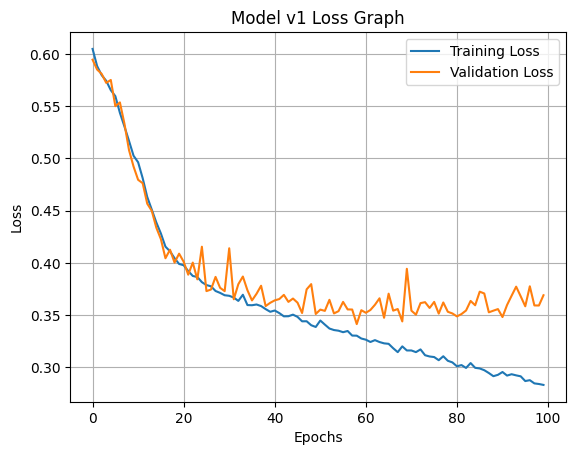

In [11]:
# History에서 loss와 val_loss 가져오기
train_loss = history_v1.history['loss']
val_loss = history_v1.history['val_loss']

# 그래프 그리기
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model v1 Loss Graph')
plt.legend()
plt.grid()
plt.show()

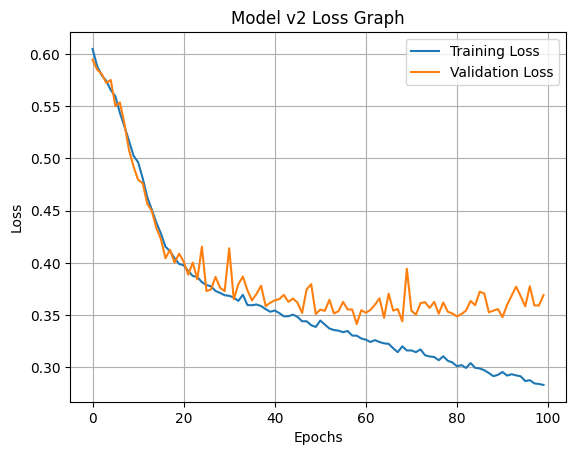

In [12]:
# History에서 loss와 val_loss 가져오기
train_loss = history_v2.history['loss']
val_loss = history_v2.history['val_loss']

# 그래프 그리기
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model v2 Loss Graph')
plt.legend()
plt.grid()
plt.show()

# 평가 지표

In [13]:
# accuracy, precision, recall, f1_score 출력 함수
def print_score(y_pred):
    accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))
    precision = precision_score(y_test, (y_pred > 0.5).astype(int))
    recall = recall_score(y_test, (y_pred > 0.5).astype(int))
    f1 = f1_score(y_test, (y_pred > 0.5).astype(int))

    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")

In [14]:
# 혼동행렬 출력 함수
def print_cm(y_pred, version):
    # 혼동행렬 계산
    cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))

    # 혼동행렬을 백분율로 변환
    cm_percentage = cm.astype('float') / cm.sum() * 100  # 전체 데이터에 대한 비율 계산

    # ConfusionMatrixDisplay에 백분율 적용
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=["Negative", "Positive"])
    disp.plot(cmap="Blues", values_format=".2f")  # 백분율 출력 형식 설정
    plt.title(f"Model {version} Confusion Matrix (Percentage)")
    plt.show()

In [15]:
# 테스트 데이터 예측
y_pred_v1 = model_v1.predict(X_test_scaled)

213/213 [==============================] - 1s 1ms/step


In [16]:
print_score(y_pred=y_pred_v1)

Accuracy: 0.837
Precision: 0.755
Recall: 0.763
F1-Score: 0.759


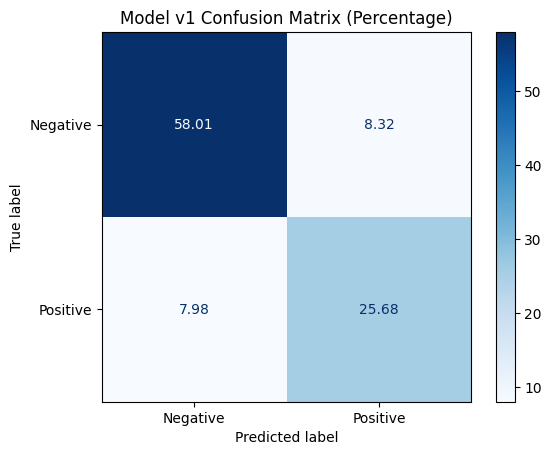

In [17]:
print_cm(y_pred_v1, 'v1')

In [18]:
y_pred_v2 = model_v2.predict(X_test_scaled)

213/213 [==============================] - 1s 2ms/step


In [19]:
print_score(y_pred=y_pred_v2)

Accuracy: 0.846
Precision: 0.772
Recall: 0.769
F1-Score: 0.770


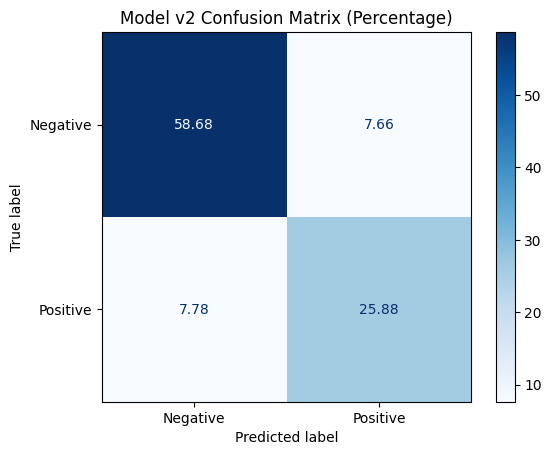

In [20]:
print_cm(y_pred_v2, 'v2')

In [ ]:
# 모델 저장
from tensorflow.python.keras.models import load_model

model_v1.save('v2x_model.h5')